# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [22]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

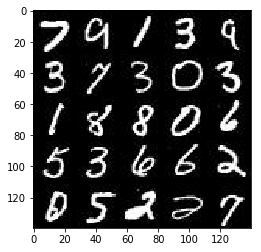

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

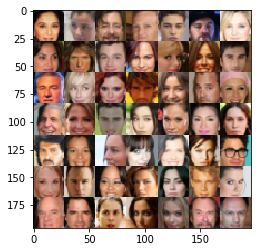

In [24]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_dim = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return input_real, z_dim, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [27]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
    
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                #Scale batch_images to -1 / 1 instead of -0.5 / 0.5
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 4.4618
Epoch 1/2... Discriminator Loss: 2.2091... Generator Loss: 3.1355
Epoch 1/2... Discriminator Loss: 0.3439... Generator Loss: 1.9356
Epoch 1/2... Discriminator Loss: 1.9016... Generator Loss: 3.7382
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 3.9018
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 2.0552... Generator Loss: 0.2086
Epoch 1/2... Discriminator Loss: 1.6571... Generator Loss: 0.6388
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.5828


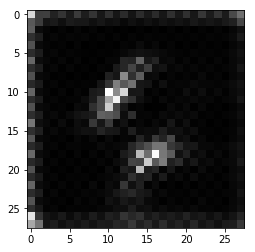

Epoch 1/2... Discriminator Loss: 2.0361... Generator Loss: 0.1608
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.3339
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.5552
Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.4930
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.4401
Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.7354


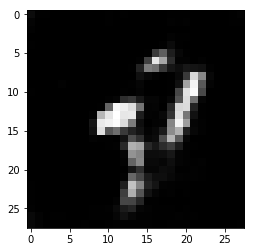

Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.3997
Epoch 1/2... Discriminator Loss: 1.4129... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 1.1790
Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 1.0674
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 2.2991
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 1.5053... Generator Loss: 1.9887
Epoch 1/2... Discriminator Loss: 1.9461... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.4948


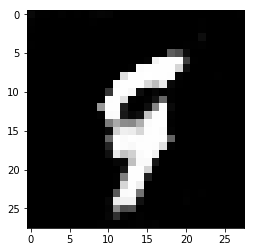

Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.5599
Epoch 1/2... Discriminator Loss: 1.4919... Generator Loss: 0.3718
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.3452
Epoch 1/2... Discriminator Loss: 1.5835... Generator Loss: 0.4785
Epoch 1/2... Discriminator Loss: 2.1630... Generator Loss: 2.2395
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 1.3084
Epoch 1/2... Discriminator Loss: 1.5826... Generator Loss: 1.4801
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 1.1677
Epoch 1/2... Discriminator Loss: 1.7085... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.9165... Generator Loss: 0.2148


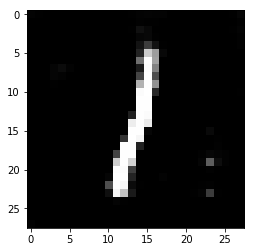

Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.7353
Epoch 1/2... Discriminator Loss: 2.1529... Generator Loss: 0.1670
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.4138
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.4780
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 1.5986
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.7162
Epoch 1/2... Discriminator Loss: 1.7192... Generator Loss: 0.2678
Epoch 1/2... Discriminator Loss: 1.6376... Generator Loss: 0.2893


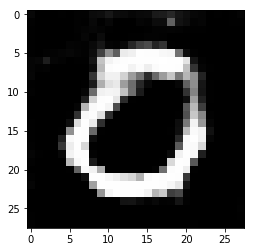

Epoch 1/2... Discriminator Loss: 2.0250... Generator Loss: 0.2075
Epoch 1/2... Discriminator Loss: 1.5781... Generator Loss: 0.2962
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.4732
Epoch 1/2... Discriminator Loss: 1.7783... Generator Loss: 0.2460
Epoch 1/2... Discriminator Loss: 1.7173... Generator Loss: 0.2554
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 0.3090
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 1.4880
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.6233
Epoch 1/2... Discriminator Loss: 1.5745... Generator Loss: 0.3810


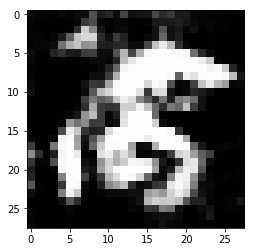

Epoch 1/2... Discriminator Loss: 1.6363... Generator Loss: 0.2726
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 1.1703
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 1.4705
Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.3566
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.3420
Epoch 1/2... Discriminator Loss: 1.7872... Generator Loss: 0.2312
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 1.6765... Generator Loss: 0.2754
Epoch 1/2... Discriminator Loss: 1.5965... Generator Loss: 0.2957
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 0.4112


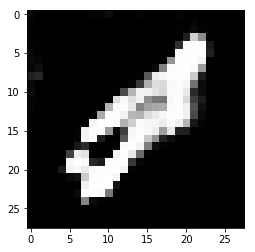

Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.4014
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 1.5131
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.6640
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 2.1936
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 1.6775
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 1.7355... Generator Loss: 0.2437


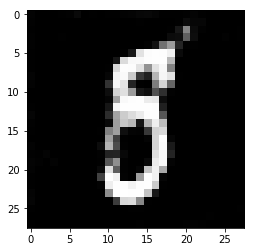

Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.4851
Epoch 1/2... Discriminator Loss: 1.6751... Generator Loss: 0.2569
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.9128... Generator Loss: 0.2021
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.3387
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 1.1927
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 1.3874
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 0.8224


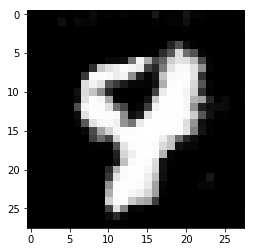

Epoch 1/2... Discriminator Loss: 1.5588... Generator Loss: 1.9665
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 2.0538... Generator Loss: 0.1653
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 1.7178... Generator Loss: 0.6808
Epoch 2/2... Discriminator Loss: 1.5186... Generator Loss: 0.3396
Epoch 2/2... Discriminator Loss: 1.7820... Generator Loss: 0.2176
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.7698
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.4403
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.3842
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.5042


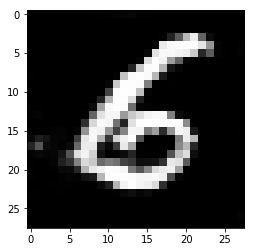

Epoch 2/2... Discriminator Loss: 2.1748... Generator Loss: 0.1489
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.5810
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.5517
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.3712
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 2.0545
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 1.4338
Epoch 2/2... Discriminator Loss: 1.5274... Generator Loss: 0.4803
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.6672... Generator Loss: 0.2524
Epoch 2/2... Discriminator Loss: 1.8411... Generator Loss: 0.2076


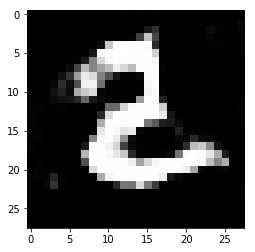

Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.5360
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.4334
Epoch 2/2... Discriminator Loss: 2.1861... Generator Loss: 0.1610
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 2.0224
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 1.5192... Generator Loss: 0.2905
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 1.8162... Generator Loss: 2.7811


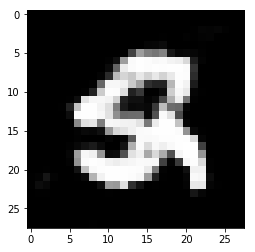

Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 1.4519
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 1.2312... Generator Loss: 0.4253
Epoch 2/2... Discriminator Loss: 1.5029... Generator Loss: 0.3337
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 1.3113
Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.4059
Epoch 2/2... Discriminator Loss: 1.7283... Generator Loss: 0.2645
Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 0.4435


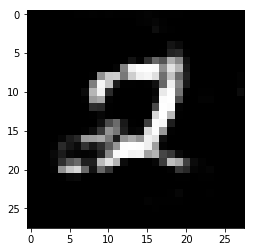

Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.3359
Epoch 2/2... Discriminator Loss: 1.5551... Generator Loss: 0.2770
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 0.5585
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 1.9954
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 1.0781
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 1.8142
Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 0.4286
Epoch 2/2... Discriminator Loss: 2.6554... Generator Loss: 0.1039
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.3893


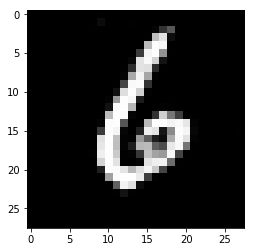

Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 1.1486... Generator Loss: 1.6978
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 2.0533
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 0.9898... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.6247
Epoch 2/2... Discriminator Loss: 2.0271... Generator Loss: 3.2163
Epoch 2/2... Discriminator Loss: 0.6424... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 0.6903


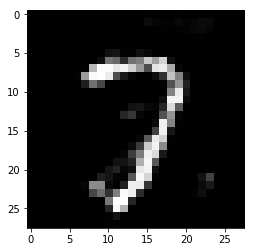

Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.3749
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.6609
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 0.4732
Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 0.8631
Epoch 2/2... Discriminator Loss: 2.7752... Generator Loss: 3.6555
Epoch 2/2... Discriminator Loss: 0.4970... Generator Loss: 1.3685
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 2.1459
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.6650


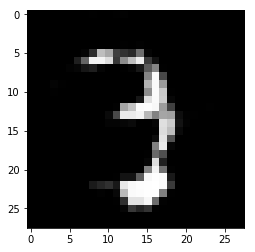

Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.5182
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 0.5588
Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.5561
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 2.1367
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.6193
Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 0.4467... Generator Loss: 1.2131
Epoch 2/2... Discriminator Loss: 0.3534... Generator Loss: 1.6880
Epoch 2/2... Discriminator Loss: 3.1210... Generator Loss: 4.1542


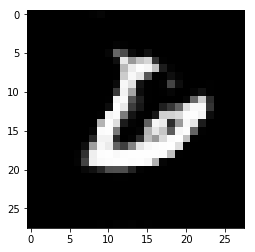

Epoch 2/2... Discriminator Loss: 0.5705... Generator Loss: 1.3646
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 1.1870
Epoch 2/2... Discriminator Loss: 1.6500... Generator Loss: 0.3117
Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 2.6294
Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 0.9577
Epoch 2/2... Discriminator Loss: 1.6865... Generator Loss: 0.2583
Epoch 2/2... Discriminator Loss: 0.7818... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 2.5882... Generator Loss: 0.1451


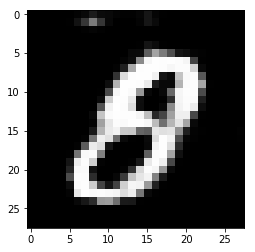

Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 1.5208
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.4361
Epoch 2/2... Discriminator Loss: 2.2213... Generator Loss: 0.1368


In [42]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 5.9510
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 1.8572... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 2.1685
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 3.1657
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.8185
Epoch 1/1... Discriminator Loss: 1.6518... Generator Loss: 1.4598
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 1.7284
Epoch 1/1... Discriminator Loss: 2.0677... Generator Loss: 0.1939
Epoch 1/1... Discriminator Loss: 2.7659... Generator Loss: 0.1046


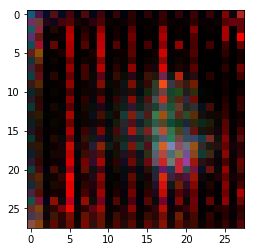

Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 1.7928
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.8191... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 1.8190
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 2.0307... Generator Loss: 0.2124
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.7545


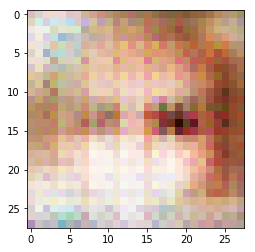

Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.3754
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.6998... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.9291... Generator Loss: 2.1062


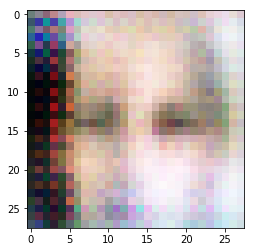

Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 2.6203... Generator Loss: 2.3204
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.6612
Epoch 1/1... Discriminator Loss: 1.7109... Generator Loss: 0.3002
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7650


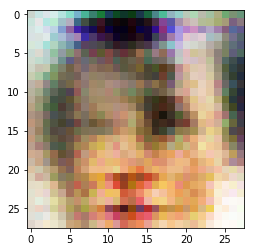

Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.8030... Generator Loss: 1.7518
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 1.1580


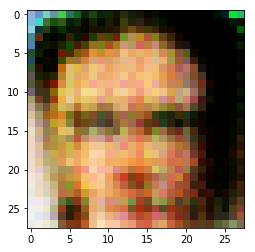

Epoch 1/1... Discriminator Loss: 1.7177... Generator Loss: 1.6239
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.9583... Generator Loss: 0.2207
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.6067


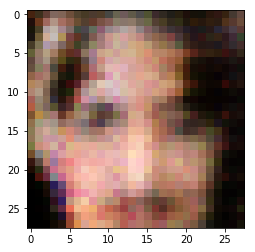

Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.3217
Epoch 1/1... Discriminator Loss: 1.7736... Generator Loss: 0.2884
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 1.4153
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.2975
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.3886
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.6733


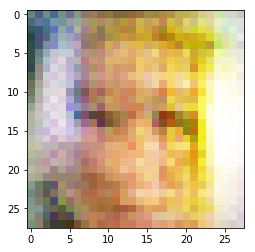

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 0.8373


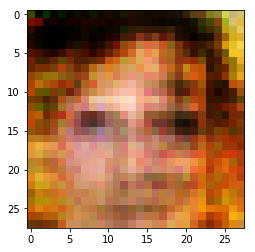

Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.4912


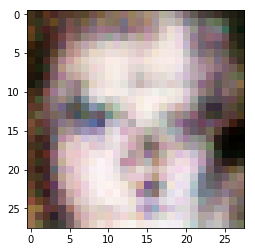

Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.3364
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 1.0114


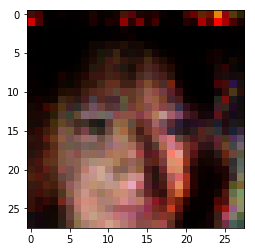

Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7569


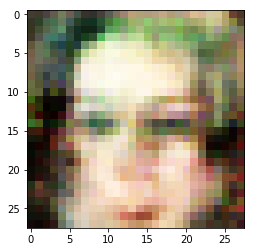

Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.2390
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.8419


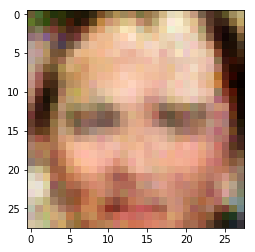

Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.7223


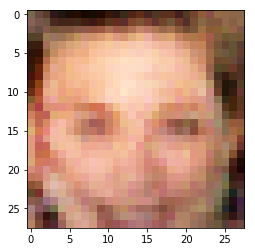

Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.6291


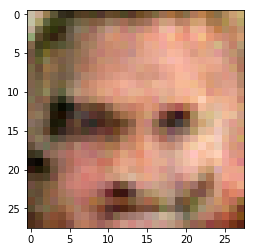

Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.2292
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.4488
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6807


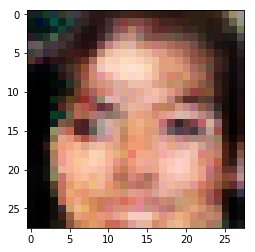

Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.8422... Generator Loss: 1.9524
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.5390


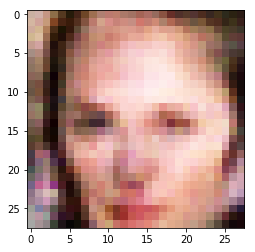

Epoch 1/1... Discriminator Loss: 1.6668... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5458


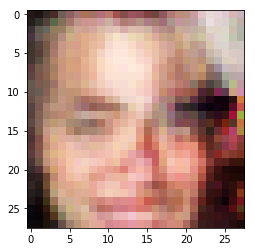

Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.9774... Generator Loss: 1.7886


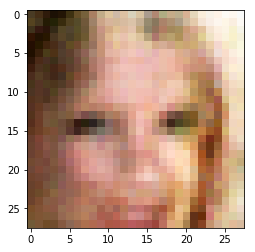

Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.5485


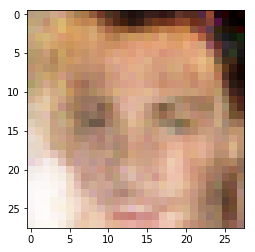

Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.5000


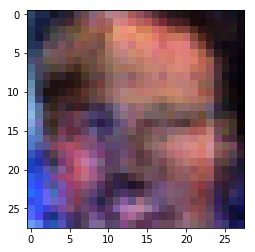

Epoch 1/1... Discriminator Loss: 1.9637... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.5819


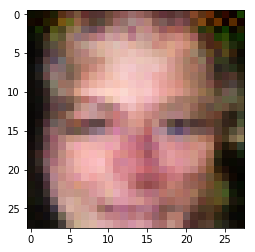

Epoch 1/1... Discriminator Loss: 1.5985... Generator Loss: 0.2841
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.9641


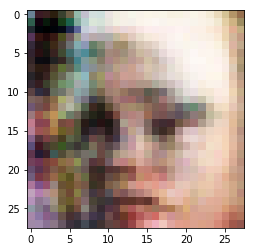

Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 0.3039
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.7422


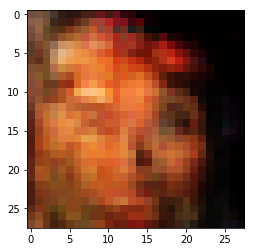

Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 0.2433
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.6068


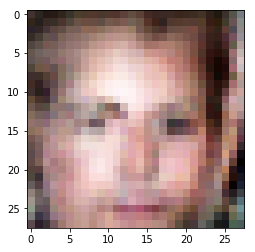

Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.4507


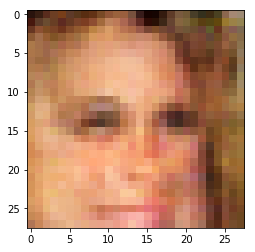

Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.7451... Generator Loss: 0.2610
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6157


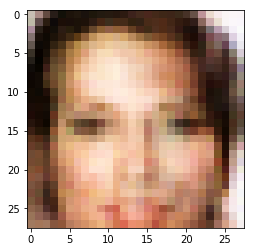

Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.7481


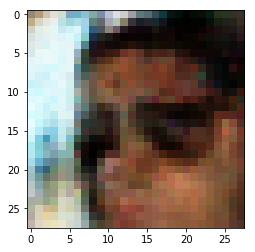

Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.4304
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.2955
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7707


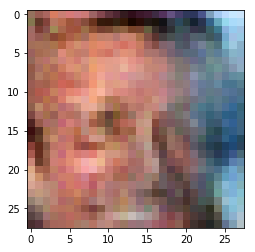

Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.8339... Generator Loss: 0.2323
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7653


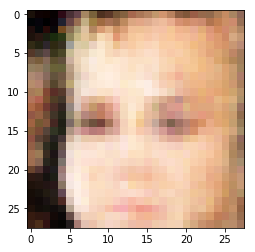

Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.2627


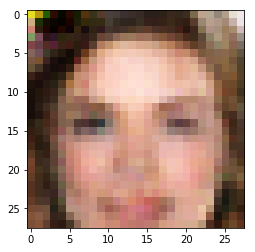

Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.0509


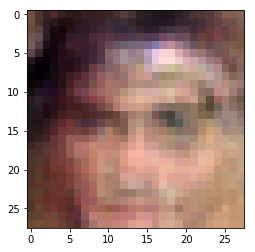

Epoch 1/1... Discriminator Loss: 1.8754... Generator Loss: 0.2277
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.9246... Generator Loss: 0.2006
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.6545


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.